# Historical Characteristics of Election Violence
***
#### Purpose:
This code aims to utilize machine learning (ML) to model characteristics of elections that correlate to election-related violence. 

#### Methodology:
Characteristics of global elections in history are used as independent input variables to train a Random Forest model to identify the level of election violence that occurred during the year leading up to and associated with a given election.

The value of the machine learning model is to extract feature importances as a method of identifying which characteristics of elections are most informative in assessing the level of violence during an election period. Permutation importance is a specific tactic for obtaining feature importances. For this analysis, it quantifies the historical characteristics of elections that correlate to election violence by measuring which features are most influential on the ML model's ability to correctly classify the level of violence associated with an election.

This analysis measures electoral violence in number of fatalities and classifies the level of electoral violence during an election cycle as one of three categories:
1. Non-fatal: no election-related fatalities recorded
2. Low-fatality: 1-3 election-related fatalities recorded
3. Mass-fatality: 4 or more election-related fatalities recorded

These categories are defined based upon a definition that 4 or more deaths constitutes a mass casualty event. ([Federal Bureau of Investigation](https://www.ojp.gov/ncjrs/virtual-library/abstracts/serial-murder-multi-disciplinary-perspectives-investigators))

#### Data Sources:
1. **Dataset of National Elections Across Democracy and Autocracy (NELDA)**
    - A historical dataset of the national elections for all independent countries from 1945-2020
    - Features Types: 
        - Election history of the country
        - Structure and quality of management of the election in question (e.g., whether opposition is allowed, delayed vote counting) 
        - Public perceptions of election fairness
        - The occurrence of protests
        - Economic and political state of the country (e.g., whether the country receives economic aid, impact of the election on US/international relations)
        - The presence of international monitors
    - Source: https://www.jstor.org/stable/23260172 or https://nelda.co/
    
    
2. **The Deadly Electoral Conflict Dataset (DECO)**
    - A georeferenced events dataset from the Uppsala Conflict Data Program (UCDP) that records incidents of electoral violence between 1989-2017 in which at least one election-related fatality occurred
    - Source: https://journals.sagepub.com/doi/full/10.1177/00220027211021620 or https://ucdp.uu.se/downloads/index.html#deco

In [1]:
# import libraries

import os
import pandas as pd
pd.set_option('display.max_columns',100)
from datetime import datetime, timedelta
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

# 1. Data Loading

In [2]:
# load data

# data directory
data_dir = 'https://raw.githubusercontent.com/wsimpso1/election-violence-risks/main/data'

deco = pd.read_csv(data_dir+'/DECO_v.1.0.csv', parse_dates=['date_start','date_end'])
nelda = pd.read_csv(data_dir+'/NELDA.csv', encoding='latin-1')
nelda_look_up = pd.read_csv(data_dir+'/nelda_look_up.csv', encoding='latin-1')


In [3]:
# inspect original data shapes prior to processing

print('DECO:', deco.shape)
print('NELDA:', nelda.shape)

DECO: (4233, 41)
NELDA: (4158, 124)


In [4]:
# datetime conversion

def custom_nelda_date_format(year, mmdd):
    '''
    parse year and month-day columns for NELDA data
    
    Parameters:
    ———————————
    year: int
    mmdd: int
        month (1-12) and day (01-31)
    
    Returns:
    ————————
    combined year-month-day date format
    '''
    try:
        date_string = f'{year}{mmdd}'
        return datetime.strptime(date_string, '%Y%m%d').date()
    # impute date for missing data 
    except:
        return datetime.strptime(f'{year}0101', '%Y%m%d').date()
        
nelda['date'] = pd.to_datetime([custom_nelda_date_format(year,date) for year, date in zip(nelda.year,nelda.mmdd)])

# 2. Exploratory Data Analysis (EDA)

### 2.1 EDA of the Dataset of National Elections Across Democracy and Autocracy (NELDA)

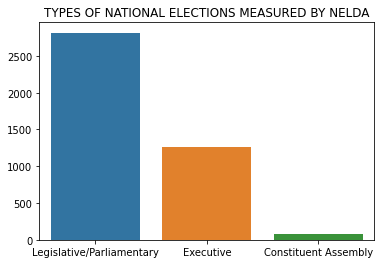

In [5]:
# types of elections recorded in dataset

election_types = nelda.types.value_counts()
sns.barplot(x=election_types.index, 
            y=election_types.values)
plt.title('TYPES OF NATIONAL ELECTIONS MEASURED BY NELDA')
plt.show()

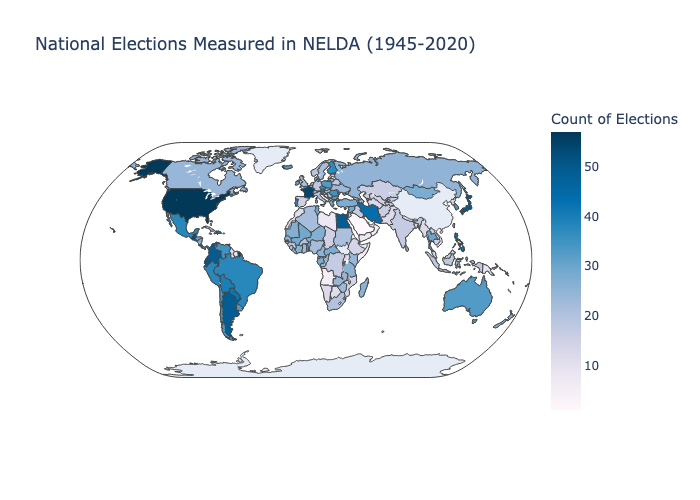

In [6]:
# count of national elections measured in NELDA

# group elections by country
nelda_count = nelda.groupby(['country']).count()['electionid'].copy().reset_index()
nelda_count = nelda_count.rename(columns={'electionid':'Count of Elections'})

# plot
fig = px.choropleth(nelda_count,
                    locations='country', 
                    locationmode="country names",
                    projection='natural earth',
                    scope="world",
                    color='Count of Elections',
                    color_continuous_scale=px.colors.sequential.PuBu, 
                    title='National Elections Measured in NELDA (1945-2020)'
                    )

# display plot
fig.show('png')

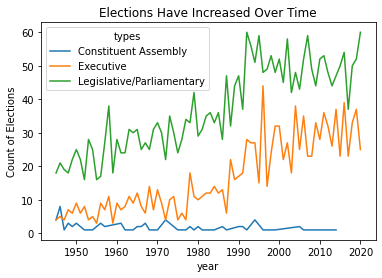

In [7]:
# count of elections over time

# group elections by year and type 
nelda_year = nelda.groupby(['year','types']).count()['electionid'].reset_index()
nelda_year = nelda_year.rename(columns={'electionid':'Count of Elections'})


# plot count of election types over time
sns.lineplot(x=nelda_year.year,
             y=nelda_year['Count of Elections'],
            hue=nelda_year.types)
plt.title('Elections Have Increased Over Time')
plt.show()

### 2.2 EDA of the Dataset of Electoral Conflict (DECO)

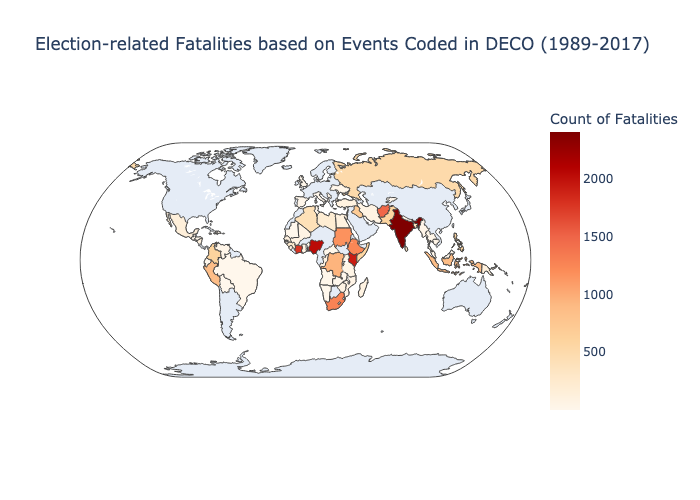

In [8]:
# count of election related fatalities in DECO

# group by country and sum number of election-related fatalities
deco_count = deco.groupby(['country']).sum()['best'].copy().reset_index()
deco_count = deco_count.rename(columns={'best':'Count of Fatalities'})

# plot map
fig = px.choropleth(deco_count,
                    locations='country', 
                    locationmode="country names",
                    projection='natural earth',
                    scope="world",
                    color='Count of Fatalities',
                    color_continuous_scale=px.colors.sequential.OrRd, 
                    title='Election-related Fatalities based on Events Coded in DECO (1989-2017)'
                    )
fig.show('png')

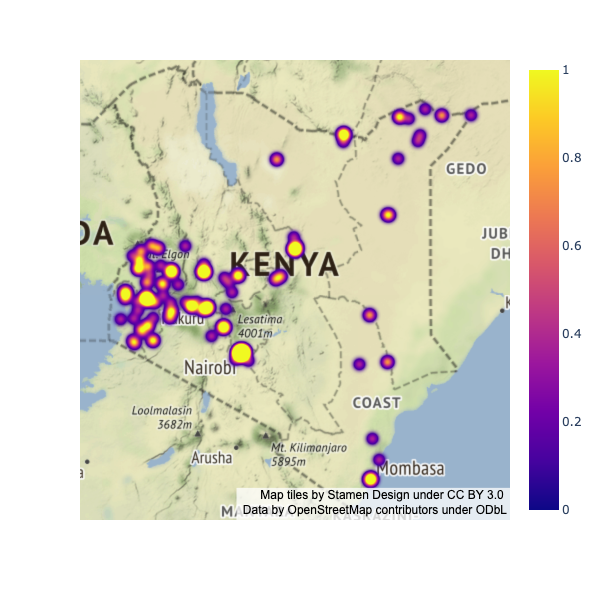

In [9]:
# examine density of election violence incidents in example country: KENYA

# select electoral violence data related to Kenya
deco_kenya = deco.loc[deco.country == 'Kenya'].copy()

# plot heatmap
fig = px.density_mapbox(deco_kenya, lat='latitude', lon='longitude', radius=10,
                        center=dict(lat=0.1, lon=38), zoom=5,
                        mapbox_style="stamen-terrain",
                        width=600, height=600)
fig.show('png')

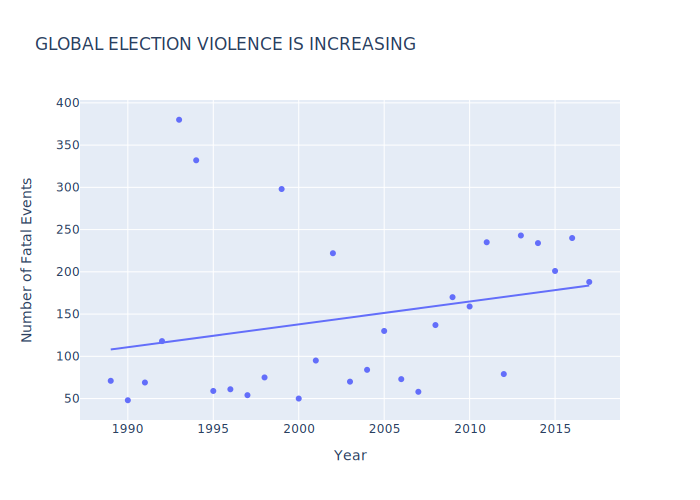

In [10]:
# election violence over time

# group data of election fatalities by year
deco_year = deco.groupby(['year']).count()['id'].reset_index()

# create scatterplot and draw linear regression trendline
fig = px.scatter(deco_year,
          x='year',
          y='id',
          trendline='ols',
          title='GLOBAL ELECTION VIOLENCE IS INCREASING',
          labels={'id':'Number of Fatal Events', 'year':'Year'})

# display plot
fig.show('svg')

# 3. Data Cleaning and Preprocessing

### 3.1 Clean and Wrangle NELDA Data of Global Historical Elections

In [11]:
# clean NELDA data of historical elections for modeling

def process_nelda(nelda_data):
    '''
    data wrangling for NELDA data
    - filters relevant data to allow merging with DECO data
    - fill NA and reformat string features to numeric
    
    Parameters:
    ———————————
    nelda_data: pandas dataframe
        original NELDA data
        
    Returns:
    ————————
    nelda_data: pandas dataframe
        processed dataframe
    '''    
    # select only years covered by both datasets (1989-2017)
    nelda_data = nelda_data.loc[(nelda_data.year > 1988) & (nelda_data.year < 2018)]
    # select only countries that appear in both datasets
    deco_country_ids = list(deco.country_id.unique())
    nelda_data = nelda_data.loc[nelda_data.ccode.isin(deco_country_ids)] 
    
    # remove notes column
    nelda_data = nelda_data[[col for col in nelda_data.columns if not re.match(".+notes$", col)]]
    
    # exclude free text features of names and location
    free_txt_cols = ['nelda43', 'nelda44', 'nelda54']
    nelda_data = nelda_data[[col for col in nelda_data.columns if col not in free_txt_cols]]
    
    # fill NaN as 'N/A' for Nelda columns
    nelda_cols = [col[0] for col in [re.findall(r'nelda\d+$', col) for col in nelda_data.columns] if len(col)>=1]
    for col in nelda_cols:
        nelda_data[col] = nelda_data[col].fillna('n/a')
    
    # convert string features to numeric
    def str_to_num(string):
        if string == 'yes':
            return 2
        elif string == 'no':
            return 1
        elif string == 'n/a': 
            return 0
        else:  # string == 'unclear'
            return -1
        
    # apply string-to-numeric function    
    for col in nelda_cols:
        nelda_data[col] = [str_to_num(val) for val in nelda_data[col]]
    
    return nelda_data.reset_index(drop=True)

In [12]:
# apply cleaning function

nelda_clean = process_nelda(nelda)

In [13]:
# view cleaned data

nelda_clean.head()

,stateid,ccode,country,electionid,year,mmdd,types,notes,nelda1,nelda2,nelda3,nelda4,nelda5,nelda6,nelda7,nelda8,nelda9,nelda10,nelda11,nelda12,nelda13,nelda14,nelda15,nelda16,nelda17,nelda18,nelda19,nelda20,nelda21,nelda22,nelda23,nelda24,nelda25,nelda26,nelda27,nelda28,nelda29,nelda30,nelda31,nelda32,nelda33,nelda34,nelda35,nelda36,nelda37,nelda38,nelda39,nelda40,nelda41,nelda42,nelda45,nelda46,nelda47,nelda48,nelda49,nelda50,nelda51,nelda52,nelda53,nelda55,nelda56,nelda57,nelda58,date
0,HAI,41,Haiti,041-1990-1216-L1,1990,1216,Legislative/Parliamentary,NaN,2,2,2,2,2,0,0,0,0,2,2,1,1,1,1,1,1,2,2,1,0,0,0,0,1,0,0,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,2,1,1,2,0,1990-12-16
1,HAI,41,Haiti,041-1990-1216-L2,1991,120,Legislative/Parliamentary,NaN,2,2,2,2,2,0,0,0,0,2,2,-1,1,1,-1,-1,1,2,2,1,0,0,0,0,-1,0,-1,-1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,-1,-1,-1,-1,0,0,2,0,1991-01-20
2,HAI,41,Haiti,041-1990-1216-P1,1990,1216,Executive,NaN,2,2,2,2,2,0,2,2,1,2,2,-1,1,1,1,-1,1,2,2,2,1,1,0,0,-1,0,2,1,0,0,0,1,2,1,0,0,0,0,2,2,1,1,2,2,1,1,1,-1,0,0,-1,0,0,2,0,1990-12-16
3,HAI,41,Haiti,041-1995-0625-L1,1995,625,Legislative/Parliamentary,The first of a two-round election. A rerun of ...,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,1995-06-25
4,HAI,41,Haiti,041-1995-0625-L2,1995,917,Legislative/Parliamentary,Boycotted by most opposition groups. There was...,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,1995-09-17


### 3.2 Clean and Wrangle DECO Data of Electoral Violence 

In [14]:
# clean data of election violence (DECO) for modeling

def process_deco(deco_data):
    '''
    data wrangling for DECO data
    - filter columns
    - aggregate election violence data by country and date
    
    Parameters:
    ———————————
    deco_data: pandas dataframe
        original DECO data
        
    Returns:
    ————————
    deco_data: pandas dataframe
        processed and aggregated data
    '''
    # select relevant columns
    deco_data = deco_data[['country_id', 'best', 'date_end']]
    # rename columns
    deco_data = deco_data.rename(columns={'best':'num_fatalities', 'date_end':'date'})
    # sum number of fatalities by country and date
    deco_data = deco_data.groupby(by=['country_id', 'date']).sum()
    
    return deco_data.reset_index()

In [15]:
# apply cleaning function

deco_agg = process_deco(deco)

In [16]:
# view cleaned data

deco_agg.head()

,country_id,date,num_fatalities
0,41,1990-12-05,7
1,41,1991-01-07,40
2,41,1991-01-27,10
3,41,2001-12-11,2
4,41,2009-06-10,1


### 3.2 Merge Preprocessed and Aggregated NELDA and DECO datasets

In [17]:
def fatalities_per_election(election_date, country_id):
    '''
    compute the total number of election related fatalities in 1 year leading up to election date
    
    Parameters:
    ———————————
    election_date: datetime object
        date of election
    country_id: int
        ISO country code
    
    Returns:
    –———————
    sum_election_fatalities: int
        aggregated number of election-related fatalities in x country 1 year leading up to election
    '''
    deco_agg_country = deco_agg.loc[deco_agg.country_id == country_id].copy()
    start_date = election_date - timedelta(days=365)
    deco_agg_country_1_year = deco_agg_country.loc[(deco_agg_country.date >= start_date) & 
                                                   (deco_agg_country.date <= election_date)]
    sum_election_fatalities = deco_agg_country_1_year.num_fatalities.sum()
    return sum_election_fatalities

deco_election_fatalities = [fatalities_per_election(date, country) for date, country in zip(nelda_clean.date, nelda_clean.ccode)]


In [18]:
# create final combined dataframe

nelda_deco = nelda_clean.copy()
nelda_deco['election_fatalities'] = deco_election_fatalities

In [19]:
# Drop unecessary columns 

drop_cols = ['stateid','ccode', 'country', 'electionid', 'year', 'mmdd', 'types', 'notes', 'date']
nelda_deco = nelda_deco.drop(drop_cols, axis=1)

In [20]:
# view combined data that will be used in modeling

# all NELDA variables will be used as independent variables to predict the dependent variable election_fatalities
# which is the best estimate of election related fatalities for that country-year.

nelda_deco.reset_index(inplace=True, drop=True)
nelda_deco.head()

,nelda1,nelda2,nelda3,nelda4,nelda5,nelda6,nelda7,nelda8,nelda9,nelda10,nelda11,nelda12,nelda13,nelda14,nelda15,nelda16,nelda17,nelda18,nelda19,nelda20,nelda21,nelda22,nelda23,nelda24,nelda25,nelda26,nelda27,nelda28,nelda29,nelda30,nelda31,nelda32,nelda33,nelda34,nelda35,nelda36,nelda37,nelda38,nelda39,nelda40,nelda41,nelda42,nelda45,nelda46,nelda47,nelda48,nelda49,nelda50,nelda51,nelda52,nelda53,nelda55,nelda56,nelda57,nelda58,election_fatalities
0,2,2,2,2,2,0,0,0,0,2,2,1,1,1,1,1,1,2,2,1,0,0,0,0,1,0,0,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,2,1,1,2,0,7
1,2,2,2,2,2,0,0,0,0,2,2,-1,1,1,-1,-1,1,2,2,1,0,0,0,0,-1,0,-1,-1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,-1,-1,-1,-1,0,0,2,0,47
2,2,2,2,2,2,0,2,2,1,2,2,-1,1,1,1,-1,1,2,2,2,1,1,0,0,-1,0,2,1,0,0,0,1,2,1,0,0,0,0,2,2,1,1,2,2,1,1,1,-1,0,0,-1,0,0,2,0,7
3,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,0
4,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,0


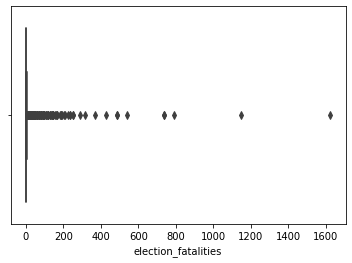

In [21]:
# visualization of fatalities distribution

sns.boxplot(x = nelda_deco.election_fatalities)
plt.show()

### 3.3 Examine Correlations for Possible Multicolinearities

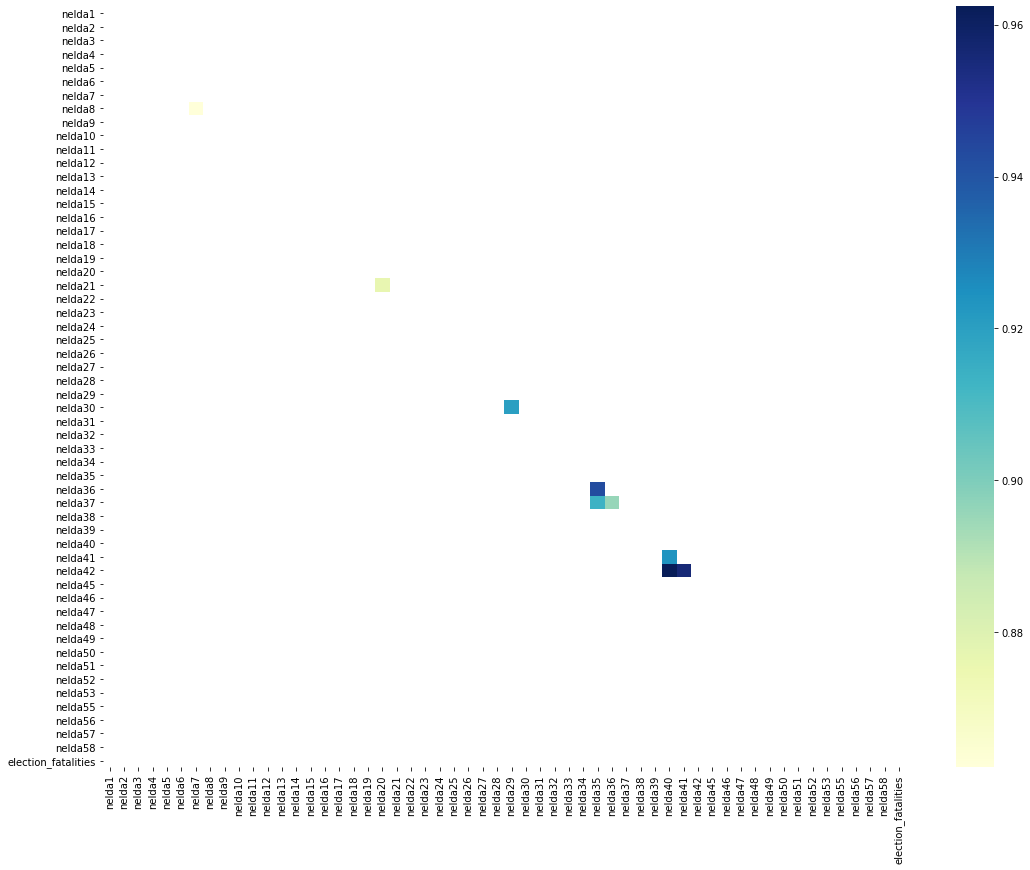

In [22]:
# visualize correlation matrix of NELDA risk factors

# calculate correlations
corr_matrix = nelda_deco.corr().abs()
mask = np.triu(np.ones_like(corr_matrix))

# examine correlations 
plt.figure(figsize=(18,14))
sns.heatmap(corr_matrix[corr_matrix>=.85], cmap='YlGnBu', mask=mask)
plt.show()

### 3.4. Remove Multicolinearity

In [23]:
# of the highly correlated features keep those that are most potentially informative

nelda_deco = nelda_deco.drop(columns=['nelda8','nelda21', 'nelda29',
                                                'nelda36', 'nelda37',
                                                'nelda40', 'nelda41'])

# 4. Model Building

### 4.1 Define features and target variable 

In [24]:
# convert target variable of fatalities to a categorical variable

def to_categorial(val):
    '''
    Discretizes numerical value of fatalities in a country-year
    
    Categories are defined according to a US Dept of Justice definition that an event
    with 4 or more fatalities constitutes mass murder
    https://www.ojp.gov/ncjrs/virtual-library/abstracts/serial-murder-multi-disciplinary-perspectives-investigators 
    
    Parameters:
    ———————————
    val: int
        number of fatalities
    
    Returns:
    ————————
    str: category of level of fatality
    '''
    if val == 0:
        return 'non-fatal'
    if 1 < val <= 3:
        return 'low fatality'
    else:
        return 'mass fatality'

In [25]:
# apply categorical conversion function

nelda_deco['election_fatalities'] = [to_categorial(row) for row in nelda_deco.election_fatalities]

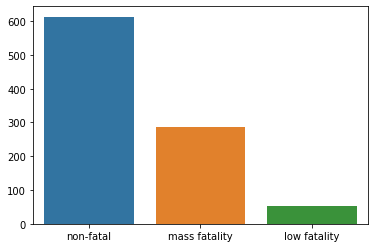

In [26]:
# view the distribution of three classes of election violence intensity

vl_ct = nelda_deco.election_fatalities.value_counts()
sns.barplot(x=list(vl_ct.keys()),
           y=vl_ct.values)
plt.show()

In [27]:
# define target variable y (election fatalities) and features X (risk factors) 

y = nelda_deco.election_fatalities
X = nelda_deco.drop(['election_fatalities'], axis=1)

Drop columns that contain information about election fatalities the model may cheat on
- nelda 33 explicitly codes for the presence of fatalities
- nelda 31 codes for the use of violence by the government against citizens

In [28]:
# drop columns as described above

X = X.drop(columns=['nelda33', 'nelda31'])

In [29]:
# transform all categorical NELDA features to one-hot encoding

# Creates list of all column headers
all_columns = list(X)
# change datatype
X[all_columns] = X[all_columns].astype(str)
# one hot encoding
X_one = pd.get_dummies(X)

In [30]:
# view final transformed dataframe for modeling

X_one.head()

,nelda1_1,nelda1_2,nelda2_-1,nelda2_1,nelda2_2,nelda3_1,nelda3_2,nelda4_-1,nelda4_1,nelda4_2,nelda5_1,nelda5_2,nelda6_-1,nelda6_0,nelda6_1,nelda6_2,nelda7_-1,nelda7_0,nelda7_1,nelda7_2,nelda9_-1,nelda9_0,nelda9_1,nelda9_2,nelda10_-1,nelda10_1,nelda10_2,nelda11_-1,nelda11_1,nelda11_2,nelda12_-1,nelda12_0,nelda12_1,nelda12_2,nelda13_-1,nelda13_0,nelda13_1,nelda13_2,nelda14_-1,nelda14_0,nelda14_1,nelda14_2,nelda15_-1,nelda15_0,nelda15_1,nelda15_2,nelda16_-1,nelda16_0,nelda16_1,nelda16_2,...,nelda45_1,nelda45_2,nelda46_-1,nelda46_0,nelda46_1,nelda46_2,nelda47_-1,nelda47_0,nelda47_1,nelda47_2,nelda48_-1,nelda48_0,nelda48_1,nelda48_2,nelda49_-1,nelda49_0,nelda49_1,nelda49_2,nelda50_-1,nelda50_0,nelda50_1,nelda50_2,nelda51_-1,nelda51_0,nelda51_1,nelda51_2,nelda52_-1,nelda52_0,nelda52_1,nelda52_2,nelda53_-1,nelda53_0,nelda53_1,nelda53_2,nelda55_-1,nelda55_0,nelda55_1,nelda55_2,nelda56_-1,nelda56_0,nelda56_1,nelda56_2,nelda57_-1,nelda57_0,nelda57_1,nelda57_2,nelda58_-1,nelda58_0,nelda58_1,nelda58_2
0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [31]:
# Adjust class imblance to mitigate overfitting via under/oversampling

# undersample the non-fatal class
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_one, y)

# oversample the other classes to eliminate class imbalance 
oversample = RandomOverSampler(sampling_strategy='all', random_state=42)
X_over, y_over = oversample.fit_resample(X_under, y_under)

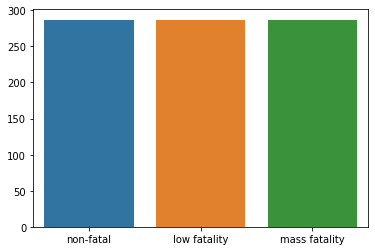

In [32]:
# view rebalanced classes

vl_ct = y_over.value_counts()
sns.barplot(x=list(vl_ct.keys()),
           y=vl_ct.values)
plt.show()

### 4.2 Train Test Split

In [33]:
# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_over, 
                                                    y_over, 
                                                    test_size=.2, 
                                                    random_state=42, 
                                                    stratify=y_over)

### 4.3 Train Model and Search for Optimal Parameters

In [34]:
# define grid search and cross validation

parameter_grid = {'n_estimators':[50, 100, 200, 300, 500, 800, 1000],
              'max_depth':[3, 4, 5, 7], 
              'criterion': ['gini', 'entropy']}

# instantiate model 
rf_model = RandomForestClassifier(random_state=42)
rf_grid_cv = GridSearchCV(rf_model, parameter_grid, verbose=1, cv=5)

In [35]:
# train

rf_grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  2.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 7],
                         'n_estimators': [50, 100, 200, 300, 500, 800, 1000]},
             verbose=1)

In [36]:
# best parameters 

rf_grid_cv.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}

In [37]:
# get predictions with best model

y_pred = rf_grid_cv.predict(X_test)

In [38]:
# training accuracy of best model

print('Train Accuracy:', round(rf_grid_cv.score(X_train, y_train)*100, 2), '%')

Train Accuracy: 93.9 %


In [39]:
# testing accuracy of best model

print('Test Accuracy:', round(rf_grid_cv.score(X_test, y_test)*100, 2), '%')

Test Accuracy: 87.86 %


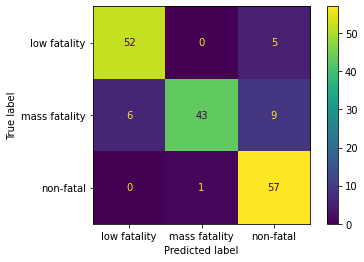

In [40]:
# granular view of model performance via confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rf_grid_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_grid_cv.classes_)
disp.plot()
plt.show()

In [41]:
# examine precision and recall from classification report

clf_rpt = classification_report(y_test, y_pred, target_names=rf_grid_cv.classes_)
print(clf_rpt)

               precision    recall  f1-score   support

 low fatality       0.90      0.91      0.90        57
mass fatality       0.98      0.74      0.84        58
    non-fatal       0.80      0.98      0.88        58

     accuracy                           0.88       173
    macro avg       0.89      0.88      0.88       173
 weighted avg       0.89      0.88      0.88       173



### 4.4 Feature Importance

In [42]:
# determine feature importances 

'''
Permutation Importance: 
A strategy to measure the decrease in model performance as the result of 
randomly shuffling one feature at a time. More important features in the model’s final decision 
cause a larger drop in performance when shuffled.
'''

r = permutation_importance(rf_grid_cv, X_test, y_test,
                           n_repeats=5,
                           random_state=0)

perm_optimized = pd.DataFrame(columns=['AVG_Importance'], index=X_test.columns)
perm_optimized['AVG_Importance'] = r.importances_mean

perm_optimized = perm_optimized.sort_values('AVG_Importance', ascending=False)
perm_optimized[:10]

,AVG_Importance
nelda11_2,0.009249
nelda20_1,0.008092
nelda16_-1,0.008092
nelda27_2,0.008092
nelda57_2,0.006936
nelda25_2,0.006936
nelda58_2,0.005780
nelda56_-1,0.005780
nelda53_1,0.005780
nelda53_2,0.005780


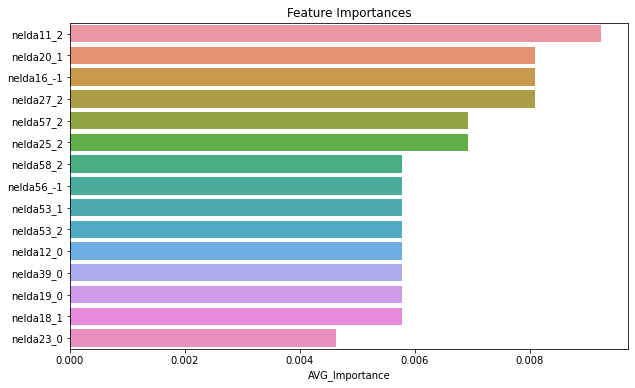

In [43]:
# visualize feature importances

plt.figure(figsize=(10,6))
sns.barplot(x=perm_optimized.AVG_Importance[:15],
            y=perm_optimized.index[:15])

plt.title('Feature Importances')
plt.show()

In [44]:
# select features with importance above threshold

importance_threshold = 0.004
perm_optimized = perm_optimized.loc[perm_optimized.AVG_Importance > importance_threshold]

In [45]:
perm_optimized

,AVG_Importance
nelda11_2,0.009249
nelda20_1,0.008092
nelda16_-1,0.008092
nelda27_2,0.008092
nelda57_2,0.006936
nelda25_2,0.006936
nelda58_2,0.005780
nelda56_-1,0.005780
nelda53_1,0.005780
nelda53_2,0.005780


# 5. Obtain Top Risk Factors of Historical Election Violence 

In [46]:
# get top most important risk factors to predicting historical election violence 

top_nelda_codes = [re.findall(r'nelda\d{1,2}',row) for row in perm_optimized.index]
top_nelda_codes = pd.DataFrame(np.concatenate(top_nelda_codes), columns=['nelda_feature'])

top_unique_nelda_codes = list(top_nelda_codes.nelda_feature.unique())

In [47]:
# look up text descriptions of top NELDA risk factors

top_nelda_code_descriptions = nelda_look_up.loc[nelda_look_up.nelda_code.isin(top_unique_nelda_codes)][['nelda_code', 'description_clean']]
top_nelda_code_descriptions = top_nelda_code_descriptions.rename(columns={'description_clean':'election_characteristic'})
top_nelda_code_descriptions.reset_index(inplace=True, drop=True)
# adjust column width to view data
pd.options.display.max_colwidth = 200
top_nelda_code_descriptions

,nelda_code,election_characteristic
0,nelda11,"Before elections, are there significant concerns that elections will not be free and fair?"
1,nelda12,Was the incumbent or ruling party confident of victory before elections?
2,nelda16,"In the run-up to the election, were there allegations of media bias in favor of the incumbent?"
3,nelda18,Is country said to be in an economic crisis?
4,nelda19,Is country said to be a large recipient of outside economic aid?
5,nelda20,Was the office of the incumbent leader contested in this election?
6,nelda23,"If the incumbent did not run and there was a chosen successor, did a successor assume power as a result of the elections?"
7,nelda24,Did the incumbent's party lose?
8,nelda25,Were there reliable polls that indicated popularity of ruling political party or of the candidates for office before elections?
9,nelda27,Was the vote count a gain for the opposition?


In [48]:
# save list of characteristics of elections that correlate to election violence according to RF model

top_nelda_code_descriptions.to_csv('FINAL_OUTPUT_characteristics_of_electoral_violence.csv')
